# Fundamentals of Deep Learning, Data Mining Minor

## Homework Assignment 1. Introduction to PyTorch. Fully Connected Neural Networks.

### General Information

Release date: 07.10.2023

Soft deadline: 23:59 MSK 20.10.2023

Hard deadline: 23:59 MSK 24.10.2023

### Grading and Penalties
The maximum possible grade for this assignment is 10 points. For each day of late submission, 1 point is deducted. Submissions after the hard deadline are not allowed.

The assignment must be completed independently. "Similar" solutions are considered plagiarism, and all involved students (including those who copied) cannot receive more than 0 points for it. If you found a solution (or part of it) for any of the tasks in an open source, you must include a link to the source in a separate section at the end of your work (you likely won't be the only one who found it, so to avoid suspicion of plagiarism, a link to the source is required).

Inefficient code implementation may negatively affect the grade.
Additionally, the grade may be reduced for poorly readable code and poorly formatted plots. All answers must be accompanied by code or comments explaining how they were obtained.

The final grade is calculated as:
$$
\min(task_1, task_2) \times 0.6 + \max(task_1, task_2) \times 0.2 + task_4 \times 0.2
$$

where $task_1$, $task_2$, and $task_4$ are the grades for the first and second tasks, respectively.
Also, a grade of 0 is assigned for the homework if task zero or task three is not completed.

### About the Assignment

In this assignment, you will predict the release year of a song (**regression task**) based on some audio features: [data](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). The code for loading the data is provided in the cells below. Please note that the training and test sets are located in the same file, so DO NOT modify the cell where the data split is performed.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-24 19:30:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [    <=>             ] 201.24M  35.1MB/s    in 6.1s    

2024-10-24 19:31:05 (33.3 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.shape

(515345, 91)

We have displayed a sample of the data to understand whether it can be used as-is. It is clear that working further with such data is questionable because, at a minimum, there are negative values that are not scaled. Additionally, the vastly different scales immediately stand out, with some values being very large and others as small as 0.075. Clearly, we will need to scale the data.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       515345 non-null  int64  
 1   1       515345 non-null  float64
 2   2       515345 non-null  float64
 3   3       515345 non-null  float64
 4   4       515345 non-null  float64
 5   5       515345 non-null  float64
 6   6       515345 non-null  float64
 7   7       515345 non-null  float64
 8   8       515345 non-null  float64
 9   9       515345 non-null  float64
 10  10      515345 non-null  float64
 11  11      515345 non-null  float64
 12  12      515345 non-null  float64
 13  13      515345 non-null  float64
 14  14      515345 non-null  float64
 15  15      515345 non-null  float64
 16  16      515345 non-null  float64
 17  17      515345 non-null  float64
 18  18      515345 non-null  float64
 19  19      515345 non-null  float64
 20  20      515345 non-null  float64
 21  21      51

## Task 0. (0 points, but failure to complete it results in a maximum score of 0 for the entire assignment)

We will use RMSE as the quality metric. For the very first baseline, train a `Ridge` regression from `sklearn`. Additionally, calculate the quality for the best constant prediction.

To complete this task (and all subsequent ones), preprocess the data.

1. Fix the random_seed everywhere possible. A function is provided for this, but you can add your own adjustments.
2. Train a StandardScaler and preprocess your data. In subsequent tasks, you may use a different scaler or even omit it.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
scaler.fit(X_train)
X_train_prep = scaler.transform(X_train)
X_test_prep = scaler.transform(X_test)

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
set_random_seed(42)

In [ ]:
set_random_seed(42)

model = Ridge(random_state = set_random_seed(42))
model.fit(X_train_prep, y_train)

y_pred = model.predict(X_test_prep)
rmse_for_model = np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
rmse_for_model

9.510160820470436

The best constant for RMSE is the mean, so let's calculate the metric value using it.

In [ ]:
set_random_seed(42)
best_rmse_metric = np.mean(y_train)
rmse_const = np.sqrt(((y_test - best_rmse_metric) ** 2).mean()) # рмсе при константе (среднем)
rmse_const


10.85246390513634

## Task 1. (maximum 10 points)

Reinforce your knowledge of how PyTorch handles backpropagation by following these steps:

1. Create a linear regression model consisting of only a single Linear layer.
2. Write a training loop for your linear regression. In it, implement the loss calculation and perform a gradient descent step. Using pre-built optimizers and loss functions from the PyTorch library is prohibited. To compute the gradient, use the `backward` method.
3. Run training for 10 epochs, checking the value of the target metric on the test set after each epoch.
4. Display graphs of the metric and loss function values on both the training and test sets.

The goal of this task is not to beat any specific metric threshold. Your task is to ensure that your handwritten training loop works correctly. To speed up computations and model training, you may use only a slice of the data instead of the entire dataset.

In [ ]:
set_random_seed(42)

class Aboba(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(X_train_prep.shape[1], 1))

    def forward(self, x):
        return self.model(x)


In [ ]:
set_random_seed(42)

model = Aboba()


X_train_tensor = torch.tensor(X_train_prep, dtype=torch.float32)[:1000]
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)[:1000]
X_test_tensor = torch.tensor(X_test_prep, dtype=torch.float32)[:1000]
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)[:1000]

epochs = 10
lr = 0.009134

train_mse = []
test_mse = []

for i in range(1, epochs + 1):
    model.train()

    y_pred_train = model(X_train_tensor)
    train_loss = ((y_pred_train - y_train_tensor) ** 2).mean()

    model.zero_grad()
    train_loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad

    model.zero_grad()

    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor)
        test_loss = ((y_pred_test - y_test_tensor) ** 2).mean()

    train_mse.append(train_loss.item())
    test_mse.append(test_loss.item())

    print(f'Номер эпохи: {i}, MSE на трейне: {train_loss.item():.4f}, MSE на тесте: {test_loss.item():.4f}')


Номер эпохи: 1, MSE на трейне: 3990364.5000, MSE на тесте: 3853646.7500
Номер эпохи: 2, MSE на трейне: 3734026.7500, MSE на тесте: 3721866.0000
Номер эпохи: 3, MSE на трейне: 3525292.5000, MSE на тесте: 3593653.7500
Номер эпохи: 4, MSE на трейне: 3345566.2500, MSE на тесте: 3469052.7500
Номер эпохи: 5, MSE на трейне: 3185061.2500, MSE на тесте: 3348387.7500
Номер эпохи: 6, MSE на трейне: 3038461.7500, MSE на тесте: 3231971.2500
Номер эпохи: 7, MSE на трейне: 2902742.5000, MSE на тесте: 3120006.7500
Номер эпохи: 8, MSE на трейне: 2776066.5000, MSE на тесте: 3012581.7500
Номер эпохи: 9, MSE на трейне: 2657228.7500, MSE на тесте: 2909681.5000
Номер эпохи: 10, MSE на трейне: 2545372.2500, MSE на тесте: 2811220.7500


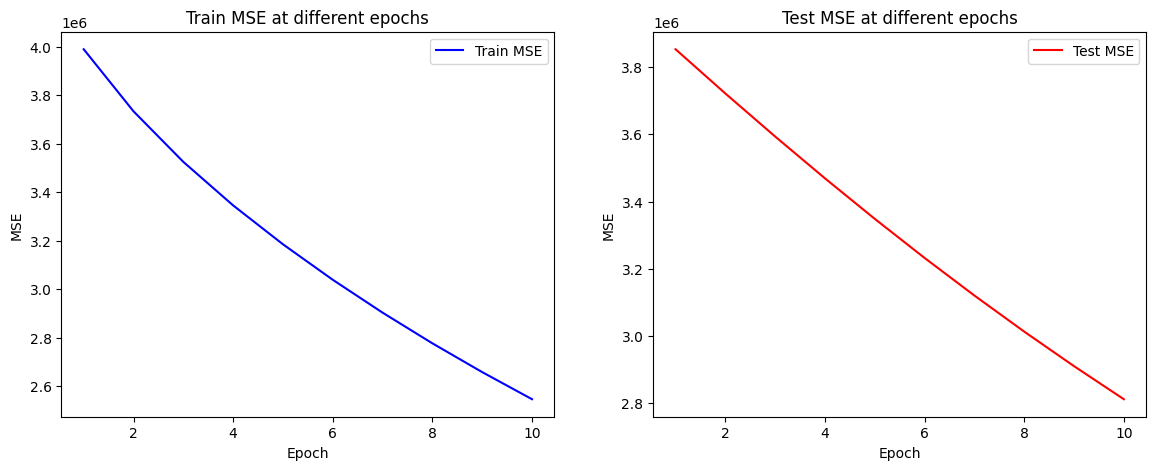

In [ ]:
epochs = range(1, 11)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_mse, label='Train MSE', color='b')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Train MSE at different epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, test_mse, label='Test MSE', color='r')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Test MSE at different epochs')
plt.legend()

plt.show()



It is interesting that the error change graph is nearly linear, and this pattern holds for both the test and training sets.

## Task 2. (maximum 10 points)

Implement the training and testing of a neural network for the provided dataset. The relationship between the obtained metric value on the test set and the points for the task is as follows:

- $\text{RMSE} \le 9.00 $ — 4 points
- $\text{RMSE} \le 8.90 $ — 6 points
- $\text{RMSE} \le 8.80 $ — 8 points
- $\text{RMSE} \le 8.75 $ — 10 points

There are several rules you must follow:

- The entire training pipeline must be written in PyTorch. You may use other libraries (`numpy`, `sklearn`, etc.), but only for data processing. That is, you can transform data and calculate metrics using these libraries as you wish, but you cannot import models from `sklearn` to achieve the required quality. Additionally, you cannot use libraries for which PyTorch itself is a dependency.

- We do not restrict your choice of model architecture, but a fully connected neural network will likely be sufficient.

- You are prohibited from using any data other than the training dataset for training.

- Model ensembling is prohibited.

### Useful tips:

- It is very unlikely that you will achieve a 10-point quality on your first attempt, so try different architectures, optimizers, and hyperparameter values. Ideally, for each new experiment, you should change only one thing to precisely understand how that factor affects the quality.

- Do not forget that **target normalization** will help improve your model's quality.

- The fact that we are doing deep learning does not mean you should forget techniques used in classical machine learning. So be sure to conduct exploratory data analysis, draw necessary plots, and remember scaling and hyperparameter tuning.

- You will likely encounter severe overfitting in your neural network. Special regularization methods exist for neural networks, such as dropout ([article](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) and weight decay ([blog post](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). They are, of course, implemented in PyTorch. Try experimenting with them.

- If you don't know something, don't hesitate to search online. There is a lot of useful information, tutorials, and advice on deep learning in general and PyTorch in particular. But remember, if you copy code without citing the source, you will be held strictly accountable!

- If you implement GPU training from the start, you will have more time for experiments, as all computations will run faster. Google Colab provides several free GPU hours (usually around 8–10) per day.

- To debug your code, you can train on a small subset of data or even on a single batch. If the loss on the training set does not decrease, something is definitely wrong!

- Use the utilities provided by PyTorch (e.g., Dataset and Dataloader). They were specifically designed to simplify the training pipeline development.

- You will likely want to track training progress. The `tqdm` library is convenient for creating progress bars.

- You might want plots to be drawn during training. You can use the [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output) function to remove the old plot and draw a new one in its place.

**YOU MUST** plot graphs of loss/metric dependence on the training and test sets over the course of training. If training involves a relatively small number of epochs, it is better to plot dependence on the training step number; if there are more epochs, plot dependence on epochs. If the reviewer does not see such a graph for your best model, they have the right to deduct points for the task.

**IMPORTANT!** Your solution must be reproducible. If it is not, the reviewer has the right to deduct points for the task. To fix the random seed, use the function from the previous task.

You can follow any reasonable code structure, but we recommend using the function signatures provided below. It's best to validate your predictions with an assertion—this will protect you from various mistakes, such as having a prediction vector consisting of only a single number. In any case, pay close attention to which tensors you calculate the RMSE metric for. If you mislead the reviewers, whether accidentally or intentionally, they will become very upset.

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [ ]:
scaler_target = StandardScaler()
y_train_scaled = scaler_target.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.reshape(-1, 1))

In [ ]:
X_train_tensor = torch.tensor(X_train_prep, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_prep, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

In [ ]:
def inverse_scaling(predict_values, scaler):
    return scaler.inverse_transform(predict_values)

In [ ]:
train_set = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_set, batch_size=50, shuffle=True)

test_set = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_set, batch_size=50, shuffle=True)

In [ ]:
model_2 = nn.Sequential(
    nn.BatchNorm1d(X_train_prep.shape[1]),
    nn.Linear(X_train_prep.shape[1], 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(256, 1))
model_2.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_2.parameters(), lr=0.001, weight_decay=1e-4)


In [ ]:
set_random_seed(42)
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    # Обучение модели
    for data_batch, target in tqdm(train_loader):
      # отправка на gpu
      data_batch = data_batch.to(device)
      target = target.to(device)

      y_pred = model_2(data_batch)
      optimizer.zero_grad()
      train_mse = criterion(y_pred, target)

      train_mse.backward()
      optimizer.step()

def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    with torch.no_grad():
      predicts = []

      for data_batch, target in test_loader:
        data_batch = data_batch.to(device)
        target = target.to(device)

        y_pred = model_2(data_batch)

        test_mse = criterion(y_pred, target)
        predicts.append(y_pred)


    predicts = torch.cat(predicts)

    return predicts


In [ ]:
train(model, optimizer, criterion, train_loader, test_loader)

  0%|          | 0/9275 [00:00<?, ?it/s]

In [ ]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

Проверка проходит, размерности совпадают

In [ ]:
import torch.nn.functional as F

set_random_seed(42)

train_losses = []
test_losses = []
train_rmse = []
test_rmse = []

epochs = 10

for epoch in range(1, epochs + 1):

    model_2.train()
    train(model_2, optimizer, criterion, train_loader, test_loader)

    model_2.eval()
    with torch.no_grad():

        pred_train = model_2(train_loader.dataset.tensors[0].to(device))

        train_inverse = inverse_scaling(pred_train.cpu().numpy(), scaler_target)

        loss_train = F.mse_loss(torch.Tensor(train_inverse), torch.Tensor(y_train).view(-1, 1))

        pred_test = model_2(test_loader.dataset.tensors[0].to(device))

        test_inverse = inverse_scaling(pred_test.cpu().numpy(), scaler_target)

        loss_test = F.mse_loss(torch.Tensor(test_inverse), torch.Tensor(y_test).view(-1, 1))

    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())
    train_rmse.append(torch.sqrt(loss_train).item())
    test_rmse.append(torch.sqrt(loss_test).item())

    print(f'Epoch: {epoch}, Train MSE: {loss_train.item():.2f}, Train RMSE: {torch.sqrt(loss_train).item():.2f}, '
          f'Test MSE: {loss_test.item():.2f}, Test RMSE: {torch.sqrt(loss_test).item():.2f}')

  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 1, Train MSE: 74.36, Train RMSE: 8.62, Test MSE: 78.02, Test RMSE: 8.83


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 2, Train MSE: 73.83, Train RMSE: 8.59, Test MSE: 77.25, Test RMSE: 8.79


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 3, Train MSE: 73.13, Train RMSE: 8.55, Test MSE: 77.81, Test RMSE: 8.82


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 4, Train MSE: 72.32, Train RMSE: 8.50, Test MSE: 76.68, Test RMSE: 8.76


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 5, Train MSE: 71.02, Train RMSE: 8.43, Test MSE: 76.43, Test RMSE: 8.74


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 6, Train MSE: 70.70, Train RMSE: 8.41, Test MSE: 76.45, Test RMSE: 8.74


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 7, Train MSE: 70.30, Train RMSE: 8.38, Test MSE: 76.08, Test RMSE: 8.72


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 8, Train MSE: 69.99, Train RMSE: 8.37, Test MSE: 76.15, Test RMSE: 8.73


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 9, Train MSE: 69.26, Train RMSE: 8.32, Test MSE: 76.14, Test RMSE: 8.73


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 10, Train MSE: 68.70, Train RMSE: 8.29, Test MSE: 76.19, Test RMSE: 8.73


In [ ]:
mean_train_mse = np.mean(train_losses)
mean_test_mse = np.mean(test_losses)


train_rmse_total = np.sqrt(mean_train_mse)
test_rmse_total = np.sqrt(mean_test_mse)
test_rmse_total

8.758983686881189

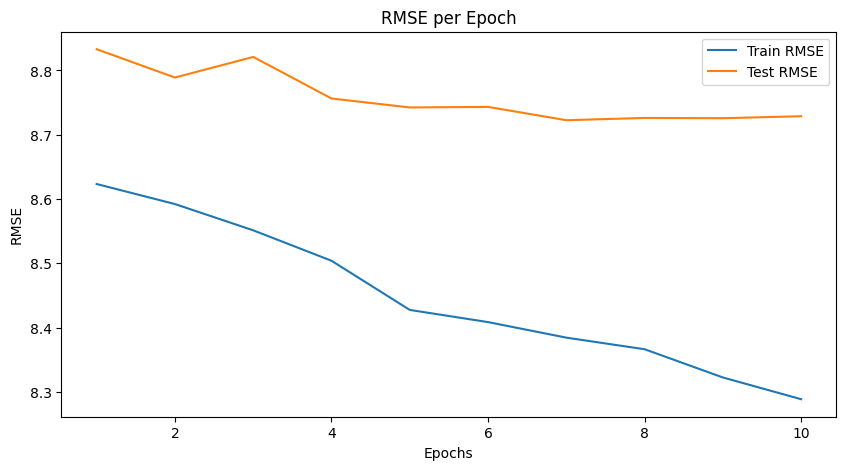

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_rmse, label='Train RMSE')
plt.plot(range(1, epochs + 1), test_rmse, label='Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('RMSE per Epoch')
plt.legend()
plt.show()

## Task 3. (0 points, but failure to complete it results in a maximum score of 0 for the entire assignment)

Write a brief report on how you achieved the obtained quality: what tools you used and what experiments you conducted. Describe in detail the architectures and hyperparameter values, as well as the test metrics they achieved. For the report to be accepted, you must include at least 3 experiments.

Изначально я не нормировал целевую переменную, а модель состояла из двух слоёв активации (в качестве функции активации я использовал ReLU) и трёх линейных слоёв. Шаг градиентного спуска был установлен на 0.02, а количество эпох — 5, чтобы сэкономить время. Сразу стало понятно, что архитектуру нужно менять, потому что RMSE менялась скачками (как видно на графике ниже).

In [ ]:
model_2 = nn.Sequential (
 nn.Linear(X_train_prep.shape[1], 500),
 nn.ReLU(),
 nn.Linear(500, 100),
 nn.ReLU(),
 nn.Linear(100, 1)
)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.02)

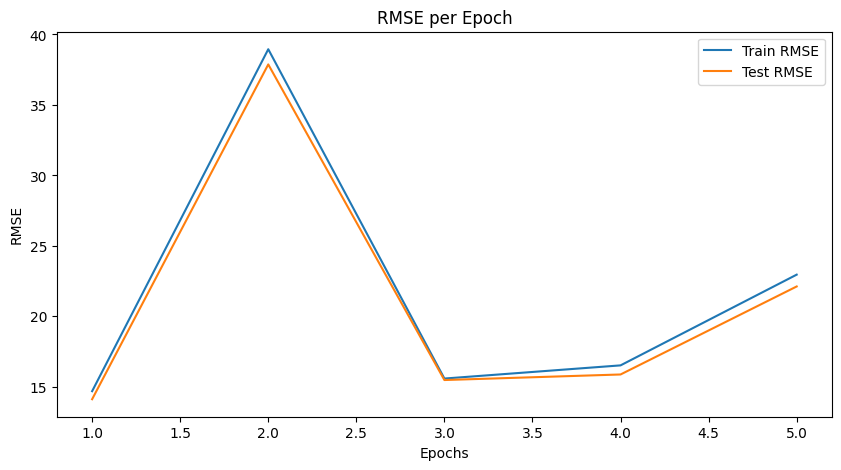

Attempt 2. In the second step, I used AdamW as the optimizer with a step size of 0.001, and batch sizes as powers of two so that their sizes decrease more evenly with each layer. I also increased the number of epochs to 10. Minimum RMSE: 8.72 on the test set. Average across all epochs: 8.78.

In [ ]:
set_random_seed(42)

model_2 = nn.Sequential(
    nn.Linear(X_train_prep.shape[1], 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_2.parameters(), lr=0.001, weight_decay=1e-4)

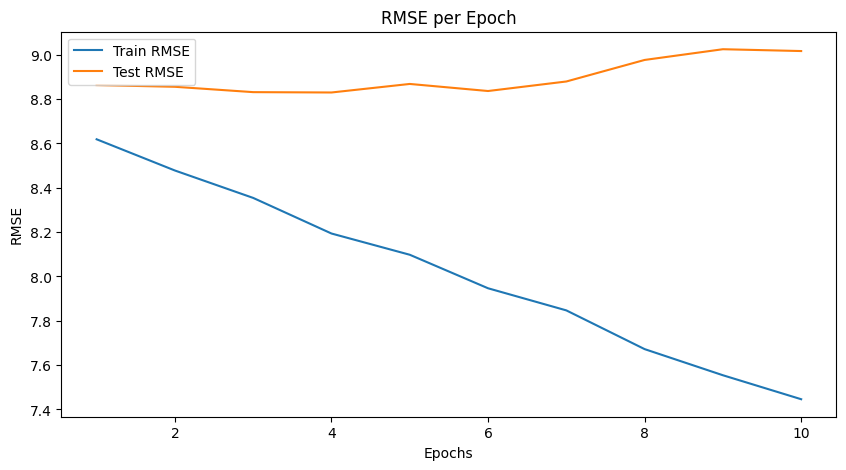

Attempt 3. Since in the second attempt I realized that my model starts overfitting after epoch 6 (as seen in the graph above), I decided to add regularization before each linear layer. I initially set the dropout parameter p to 0.3. From the graph below, I saw that the situation improved despite the fluctuations, so I decided to try reducing the dropout parameter p. Minimum RMSE: 8.80 on the test set. Average across all epochs: 8.84.

In [ ]:
set_random_seed(42)

model_2 = nn.Sequential(
    nn.Linear(X_train_prep.shape[1], 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1)
)
model_2.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_2.parameters(), lr=0.001, weight_decay=1e-4)

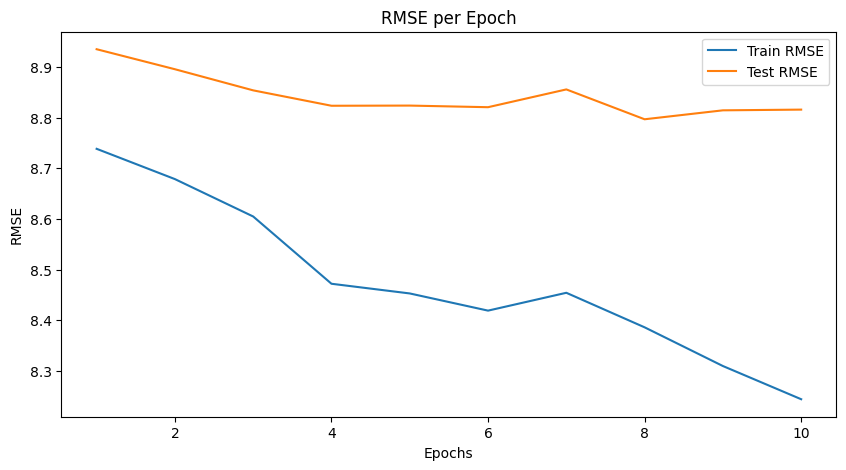

Attempt 4. Overall, the quality slightly decreased, but now the model overfits less. Minimum RMSE: 8.82 on the test set. Average across all epochs: 8.85 on the test set.

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(X_train_prep.shape[1], 512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(256, 1)
)
model_2.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_2.parameters(), lr=0.001, weight_decay=1e-4)

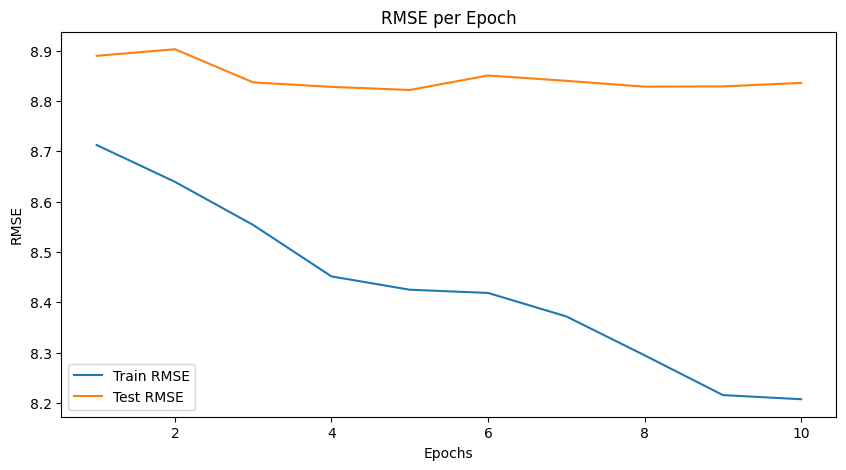

Attempt 5. On the 5th step, I finally added batch normalization before each linear layer—and hooray, the minimum RMSE became 8.72, with an average over 10 epochs of 8.76. I tried adjusting the gradient descent step size, but the difference was insignificant, so I left it as is.

## Task 4. (10 points)

Now let's try solving a classification task on the same data!

Test two approaches:

1. Treat each year in the dataset as a separate class.
2. Split the years into 10 bins and solve the classification task for 10 classes.

In the test, include calculation of the metrics: accuracy, precision, recall (you can choose micro or macro averaging as you see fit).

What can be said about the obtained models? Why did the results turn out this way? Write a brief analysis of what was done, how classification models differ from the regression task, and how they differ from each other.

In [ ]:
model = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
optimizer = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [ ]:
def test_classification(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    predicts = torch.ones(len(test_loader.dataset))
    return predicts

In [ ]:
assert test_classification(model, criterion, test_loader).shape[0] == y_test.shape[0]